In [1]:
import sys
sys.argv = ['']
from functools import reduce
import numpy as np
import pandas as pd
import argparse
import torch
import os
import datetime
import time
from random import uniform
from math import sqrt
from torch import nn
import csv
import json
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Below is the code for DS implementation for training a calssifier nueral netwrok regarding the Robust oprimisation example.

In [2]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def save_dictionary_to_file(filename, dictionary):
    with open(filename, 'w') as file:
        json.dump(dictionary, file, cls=NpEncoder)


def save_dictionary_settings(filename, dictionary):
    for k, v in dictionary.items():
        if isinstance(v, np.int64):
            dictionary[k] = int(v)

    with open(filename, "w") as myfile:
        json.dump(dictionary, myfile)


def write_list_of_lists(filename, lists):
    with open(filename, "w") as f:
        writer = csv.writer(f)
        writer.writerows(lists)


def clear_file(file):
    with open(file, "w") as _:
        pass


def append_file(msg, file):
    with open(file, "a") as f:
        f.write(msg + '\n')

In [3]:
def get_total_parameters_for_layer(param):
    return reduce(lambda x, y: x * y, np.array(param.detach().shape))


def get_total_number_of_parameters(parameters):
    total_number_of_parameters = 0

    for param in parameters:
        if param.requires_grad:
            total_number_of_parameters += get_total_parameters_for_layer(param)

    return total_number_of_parameters


def add_direction_to_parameters(parameters, random_direction):
    pos = 0

    for param in parameters:
        if param.requires_grad:
            total_parameters_for_layer = get_total_parameters_for_layer(param)
            param.data = param.detach() + random_direction[pos:pos + total_parameters_for_layer].view(param.shape)
            pos += total_parameters_for_layer

In [4]:
class Model(torch.nn.Module):

    def __init__(self, num_features, num_samples, regularization_lambda, device, hidden_size=50):
        super(Model, self).__init__()
        self.p = torch.tensor([1 / num_samples] * num_samples, requires_grad=True, dtype=torch.float32, device=device)
        self.regularization_lambda = regularization_lambda
        self.num_samples = num_samples

        self.hidden = nn.Linear(num_features, hidden_size)
        self.hidden_act = nn.LeakyReLU(negative_slope=0.1)
        self.out = nn.Linear(hidden_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)
        x = self.hidden_act(x)
        x = self.out(x)
        x = self.out_act(x)
        return x


def initialize_model(model, device, seed=42, divider=1000):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_parameters_for_layer = get_total_parameters_for_layer(param)
            if len(param.shape) == 1:  # bias
                param.data = torch.zeros(param.shape, requires_grad=True, dtype=torch.float32, device=device).data
            else:
                param.data = ((torch.rand(total_parameters_for_layer, requires_grad=True, dtype=torch.float32,
                                          device=device) - 0.5) / divider).reshape(param.shape).data

In [5]:
EPS = 1e-12


def bce_loss(model, predictions, classes):
    """ Weighted cross entropy loss """
    loss = -((predictions + EPS).log() * classes + (1 - predictions + EPS).log() * (1 - classes))
    return torch.mean(loss.view(-1) * model.p)


def robustness_loss(model):
    return - model.regularization_lambda * torch.sum((model.p - 1 / model.num_samples) ** 2)


def total_loss(model, features, classes):
    predictions = model(features)
    return bce_loss(model, predictions, classes) + robustness_loss(model)

The DS algorithm is implemented below.

In [6]:
class ConvergedException(Exception):
    pass


def sample_spherical(dims, sigma, device):
    """ Sample new random direction """
    vec = np.random.randn(dims) * sigma
    return torch.tensor(vec, device=device, dtype=torch.float32)


def rho(constant, x):
    """ Forcing function """
    return constant * x ** 2


class DROptimizer:
    sigma = None

    def __init__(self, parameters, beta_1=0.6, beta_2=0.9, gamma=1.1, sigma_max=0.5, sigma_initial=0.1,
                 rho_parameter=0.1, break_unsuccessful_steps=250, restart_sigma=1e-7, device='cpu'):
        """
        Parameters of the DR optimizer
        To accelerate training, sigma parameter is kept even for the max problem within iterations
        Since we are also dealing with a non-convex problem, sigma may be restarted to a specified
        value, if reduced below a specified threshold
        """
        self.parameters = list(parameters)
        self.num_parameters = get_total_number_of_parameters(self.parameters)
        self.device = device

        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.gamma = gamma
        self.sigma_max = sigma_max
        self.break_unsuccessful_steps = break_unsuccessful_steps
        self.restart_sigma = restart_sigma
        self.sigma = sigma_initial

        self.rho_parameter = rho_parameter

    def step(self, loss_function, *args):
        previous_loss = loss_function(*args)

        evaluations = 0
        while True:
            evaluations += 1
            # Update sigma every this many unsuccessful steps
            if evaluations % self.break_unsuccessful_steps == 0:
                self.sigma = uniform(self.beta_1 * self.sigma, self.beta_2 * self.sigma)
                self.sigma = min(self.sigma, self.sigma_max)
                if self.sigma < self.restart_sigma:
                    self.sigma = self.sigma_max
                    raise ConvergedException('problem converged')

            # sample new direction and update the parameters
            direction = sample_spherical(self.num_parameters, self.sigma, self.device)
            add_direction_to_parameters(self.parameters, direction)

            new_loss = loss_function(*args)

            if new_loss < previous_loss - rho(self.rho_parameter, self.sigma):
                self.sigma = uniform(self.sigma, self.gamma * self.sigma)
                return evaluations, new_loss.cpu().item()

            add_direction_to_parameters(self.parameters, - direction)


In [7]:
def get_accuracy(predictions, classes):
    predictions = (predictions > 0.5).view(-1).detach().cpu().numpy().astype(int)
    acc=accuracy_score(classes, predictions)
    return acc

def accuracy_for_class(predictions, classes, class_value):
    # Filter true and predicted labels for the specified class
    predictions = (predictions > 0.5).view(-1).detach().cpu().numpy().astype(int)
    true_class = [classes[i] for i in range(len(classes)) if classes[i] == class_value]
    pred_class = [predictions[i] for i in range(len(predictions)) if classes[i] == class_value]

    # Calculate accuracy for the specified class
    correct_predictions = sum(1 for true, pred in zip(true_class, pred_class) if true == pred)
    total_samples = len(true_class)

    if total_samples == 0:
        return 0.0  # Avoid division by zero

    accuracy = correct_predictions / total_samples
    return accuracy


def run_robust():
    # Read data
    data = pd.read_csv(args.data_file, header=None)

    classes, features = np.array([[0] if val == 'M' else [1] for val in data.loc[:, 1].values],
                                 dtype=np.int), data.loc[:, 2:].values
    features_tensor = torch.tensor(features, dtype=torch.float32, requires_grad=False).to(args.device)
    classes_tensor = torch.tensor(classes, dtype=torch.float32, requires_grad=False).to(args.device)

    # save results
    # if not os.path.exists(args.save_results_folder):
    #     if args.verbose:
    #         print('Creating', args.save_results_folder)
    #     os.makedirs(args.save_results_folder)

    # save_file = os.path.join(args.save_results_folder, args.save_results_file)
    # clear_file(save_file)
    Test_acc = np.zeros((args.num_epochs,args.num_folds))
    Train_acc = np.zeros((args.num_epochs,args.num_folds))
    Test_acc0 = np.zeros((args.num_epochs,args.num_folds))
    Train_acc0 = np.zeros((args.num_epochs,args.num_folds))
    Test_acc1 = np.zeros((args.num_epochs,args.num_folds))
    Train_acc1 = np.zeros((args.num_epochs,args.num_folds))
    j=0
    kf = KFold(n_splits=args.num_folds, random_state=42, shuffle=True)
    kf.get_n_splits(features_tensor)
    ntime = []
    for train_index, test_index in kf.split(features_tensor):
        start = time.time()
        x_train, x_test = features_tensor[train_index], features_tensor[test_index]
        y_train, y_test = classes_tensor[train_index], classes_tensor[test_index]

        # Create model
        model = Model(x_train.shape[1], x_train.shape[0], args.reg_parameter, args.device, hidden_size=args.hidden_size)
        model.to(args.device)
        initialize_model(model, args.device, seed=42)

        DR_optimizer_max = DROptimizer([model.p], beta_1=args.beta1_sigma, beta_2=args.beta2_sigma,
                                       gamma=args.gamma_sigma, sigma_max=args.sigma_max_value,
                                       sigma_initial=args.initial_value, rho_parameter=args.rho_parameter_max,
                                       break_unsuccessful_steps=args.break_unsuccessful_steps,
                                       restart_sigma=args.restart_sigma, device=args.device)
        DR_optimizer_min = DROptimizer(model.parameters(), beta_1=args.beta1_sigma, beta_2=args.beta2_sigma,
                                       gamma=args.gamma_sigma, sigma_max=args.sigma_max_value,
                                       sigma_initial=args.initial_value, rho_parameter=args.rho_parameter_max,
                                       break_unsuccessful_steps=args.break_unsuccessful_steps,
                                       restart_sigma=args.restart_sigma, device=args.device)

        # minimize the negative as the maximization target
        negative_total_loss = lambda *x: - total_loss(*x)

        for epoch in range(args.num_epochs):

            try:
                # Start multiple steps for the max problem
                # To minimize evaluations we avoid performing iterations where norm of the gradient is already too small
                # also the same parameter sigma_max is kept throughout iterations for the max problem
                # (this can still be updated by the direct search algorithm)

                for max_iter in range(args.number_of_max_steps):
                    _, loss_d = DR_optimizer_max.step(negative_total_loss, model, x_train, y_train)
            except ConvergedException:
                pass

            try:
                # Perform a single step for the min problem
                _, loss_g = DR_optimizer_min.step(total_loss, model, x_train, y_train)
            except ConvergedException:
                # here we could terminate the algorithm if we had run the max problem until convergence
                # we do not do that here so keep going ...
                pass

            predictions = model(x_train)
            Train_acc[epoch,j] = get_accuracy(predictions, y_train.numpy())
            Train_acc0[epoch,j] = accuracy_for_class(predictions, y_train.numpy(),class_value=0)
            Train_acc1[epoch,j] = accuracy_for_class(predictions, y_train.numpy(),class_value=1)

            predictions = model(x_test)
            Test_acc[epoch,j] = get_accuracy(predictions, y_test.numpy())
            Test_acc0[epoch,j] = accuracy_for_class(predictions, y_test.numpy(),class_value=0)
            Test_acc1[epoch,j] = accuracy_for_class(predictions, y_test.numpy(),class_value=1)
            # Temporary dump accuracies to the specified save file
            # if args.verbose and epoch % 10 == 0:
            #     predictions = model(x_train)
            #     train_acc = get_accuracy(predictions, y_train.numpy())
            #     predictions = model(x_test)
            #     test_acc = get_accuracy(predictions, y_test.numpy())
            #     res = "Epoch {:4d} train-acc {} test-acc {}".format(epoch, train_acc, test_acc)
            #     print(res)
            #append_file(res, save_file)
        j = j+1
        end = time.time()
        ntime.append(end-start)
    return Train_acc,Train_acc0,Train_acc1,Test_acc,Test_acc0,Test_acc1,ntime




In [8]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_file", type=str, default='wdbc.data')
    parser.add_argument("--hidden_size", type=int, default=50, help="Hidden size of the MLP")
    parser.add_argument("--num_folds", type=int, default=10)
    parser.add_argument("--device", type=str, default="cpu")

    ts = time.time()
    curr_datetime = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    folder = 'robust_results_' + curr_datetime + '/'
    parser.add_argument("--save_results_folder", type=str, default=folder)
    parser.add_argument("--save_results_file", type=str, default="results.txt")

    parser.add_argument("--number_of_max_steps", type=int, default=5,
                        help="Number of max steps to perform for every min step.")
    parser.add_argument("--break_unsuccessful_steps", type=int, default=500,
                        help="Update sigma every this many unsuccessful updates")


    parser.add_argument("--beta1_sigma", type=float, default=0.6)
    parser.add_argument("--beta2_sigma", type=float, default=0.9)
    parser.add_argument("--gamma_sigma", type=float, default=1.1)
    parser.add_argument("--restart_sigma", type=float, default=1e-6)
    parser.add_argument("--initial_value", type=float, default=0.001)
    parser.add_argument("--sigma_max_value", type=float, default=0.5)
    parser.add_argument("--rho_parameter_min", type=float, default=.1)
    parser.add_argument("--rho_parameter_max", type=float, default=.1)

    parser.add_argument("--reg_parameter", type=float, default=.05,
                        help="Regularization parameter for the robust optimization problem")
    parser.add_argument("--num_epochs", type=int, default=351)
    parser.add_argument("--verbose", type=int, default=1)
    args = parser.parse_args()

    Train_acc_DR,Train_acc0_DR,Train_acc1_DR,Test_acc_DR,Test_acc0_DR,Test_acc1_DR,ntime2=run_robust()

/tmp/ipykernel_4930/2212587440.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int), data.loc[:, 2:].values


Saving the results to use them in RMM_NN2.ipynb file for comparison.

In [9]:
np.save('Train_acc_DR.npy', Train_acc_DR)
np.save('Train_acc0_DR.npy', Train_acc0_DR)
np.save('Train_acc1_DR.npy', Train_acc1_DR)
np.save('Test_acc_DR.npy', Test_acc_DR)
np.save('Test_acc0_DR.npy', Test_acc0_DR)
np.save('Test_acc1_DR.npy', Test_acc1_DR)
np.save('ntime2.npy', np.array(ntime2))

In [10]:
# Train_acc_DR = np.load('Train_acc_DR.npy')
# Train_acc0_DR = np.load('Train_acc0_DR.npy')
# Train_acc1_DR = np.load('Train_acc1_DR.npy')
# Test_acc_DR = np.load('Test_acc_DR.npy')
# Test_acc0_DR = np.load('Test_acc0_DR.npy')
# Test_acc1_DR = np.load('Test_acc1_DR.npy')

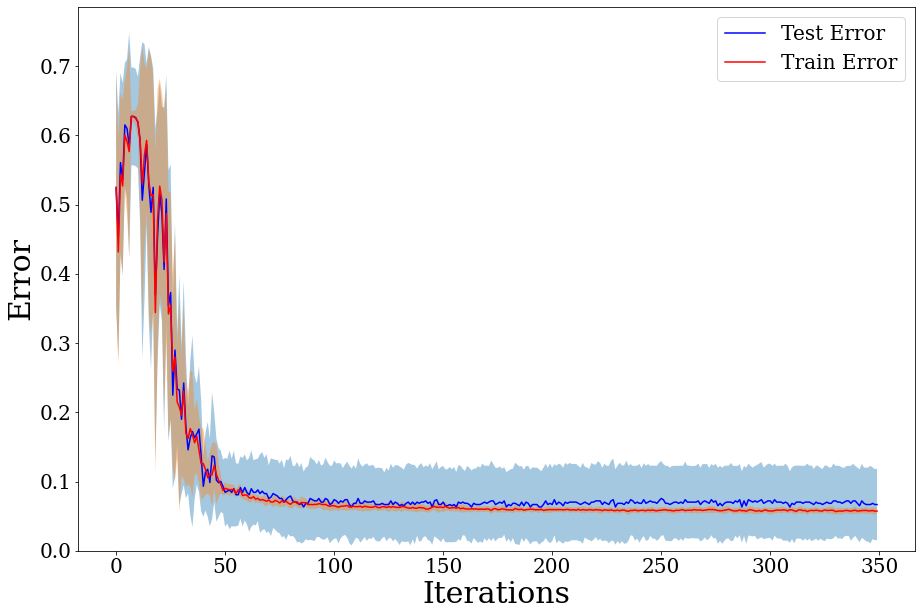

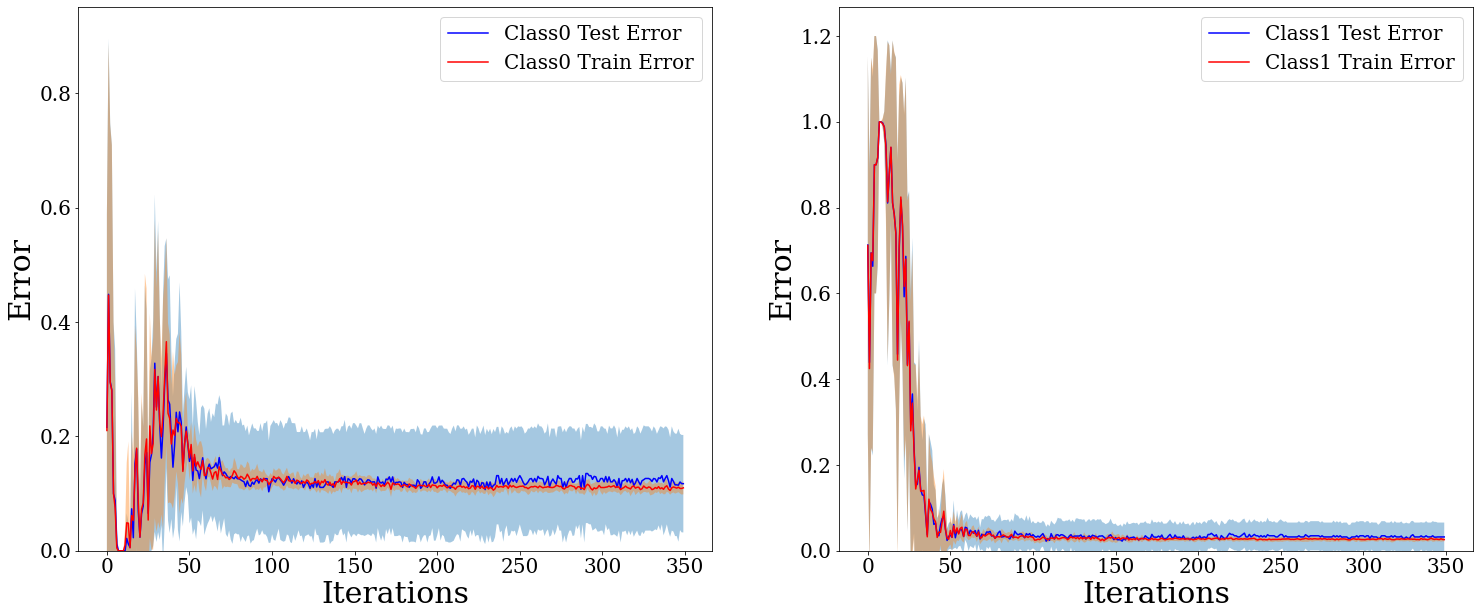

In [11]:
Train_error_DR = 1-Train_acc_DR[0:-1,:] 
Train_error0_DR = 1-Train_acc0_DR[0:-1,:]
Train_error1_DR = 1-Train_acc1_DR[0:-1,:] 
Test_error_DR = 1-Test_acc_DR[0:-1,:] 
Test_error0_DR = 1-Test_acc0_DR[0:-1,:] 
Test_error1_DR = 1-Test_acc1_DR[0:-1,:] 

# Calculate mean and standard deviation along axis 1 (across runs)
mean_accuracy_test_DR = np.mean(Test_error_DR, axis=1)
std_dev_accuracy_test_DR = np.std(Test_error_DR, axis=1)
mean_accuracy_test0_DR = np.mean(Test_error0_DR, axis=1)
std_dev_accuracy_test0_DR = np.std(Test_error0_DR, axis=1)
mean_accuracy_test1_DR = np.mean(Test_error1_DR, axis=1)
std_dev_accuracy_test1_DR = np.std(Test_error1_DR, axis=1)

mean_accuracy_train_DR = np.mean(Train_error_DR, axis=1)
std_dev_accuracy_train_DR = np.std(Train_error_DR, axis=1)
mean_accuracy_train0_DR = np.mean(Train_error0_DR, axis=1)
std_dev_accuracy_train0_DR = np.std(Train_error0_DR, axis=1)
mean_accuracy_train1_DR = np.mean(Train_error1_DR, axis=1)
std_dev_accuracy_train1_DR = np.std(Train_error1_DR, axis=1)



font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(mean_accuracy_test_DR, label='Test Error',color='blue')

plt.fill_between(range(len(mean_accuracy_test_DR)),
                 mean_accuracy_test_DR - std_dev_accuracy_test_DR,
                 mean_accuracy_test_DR + std_dev_accuracy_test_DR,
                 alpha=0.4)

plt.plot(mean_accuracy_train_DR, label='Train Error',color='red')

plt.fill_between(range(len(mean_accuracy_train_DR)),
                 mean_accuracy_train_DR - std_dev_accuracy_train_DR,
                 mean_accuracy_train_DR + std_dev_accuracy_train_DR,
                 alpha=0.4)

plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.legend(loc='best', prop=font1)
# plt.savefig('Pics/Both.pdf', format='pdf')
plt.show()

plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(mean_accuracy_test0_DR, label='Class0 Test Error',color='blue')

plt.fill_between(range(len(mean_accuracy_test0_DR)),
                 mean_accuracy_test0_DR - std_dev_accuracy_test0_DR,
                 mean_accuracy_test0_DR + std_dev_accuracy_test0_DR,
                 alpha=0.4)

plt.plot(mean_accuracy_train0_DR, label='Class0 Train Error',color='red')

plt.fill_between(range(len(mean_accuracy_train0_DR)),
                 mean_accuracy_train0_DR - std_dev_accuracy_train0_DR,
                 mean_accuracy_train0_DR + std_dev_accuracy_train0_DR,
                 alpha=0.4)

plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)

plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(mean_accuracy_test1_DR, label='Class1 Test Error',color='blue')

plt.fill_between(range(len(mean_accuracy_test1_DR)),
                 mean_accuracy_test1_DR - std_dev_accuracy_test1_DR,
                 mean_accuracy_test1_DR + std_dev_accuracy_test1_DR,
                 alpha=0.4)

plt.plot(mean_accuracy_train1_DR, label='Class1 Train Error',color='red')

plt.fill_between(range(len(mean_accuracy_train1_DR)),
                 mean_accuracy_train1_DR - std_dev_accuracy_train1_DR,
                 mean_accuracy_train1_DR + std_dev_accuracy_train1_DR,
                 alpha=0.4)

plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.legend(loc='best', prop=font1)
# plt.savefig('Pics/class10.pdf', format='pdf')
plt.show()